# **Analisis Prediksi Serangan Jantung Menggunakan PySpark**



## **Pendahuluan**

### **Latar Belakang:** Serangan jantung adalah salah satu penyebab utama kematian di seluruh dunia. Dengan kemajuan dalam ilmu data, memungkinkan untuk menggunakan data medis untuk memprediksi risiko serangan jantung berdasarkan parameter kesehatan tertentu.

### **Tujuan:**
- Melakukan analisis data eksplorasi (EDA) untuk memahami faktor-faktor utama yang berkontribusi terhadap risiko serangan jantung.

- Membangun model prediktif menggunakan PySpark untuk mengidentifikasi pasien yang berisiko tinggi terkena serangan jantung.

### **Dataset:**
Dataset, “Dataset Analisis & Prediksi Serangan Jantung,” bersumber dari Kaggle. Dataset ini berisi fitur medis seperti usia, tekanan darah, kadar kolesterol, detak jantung maksimum, dan fitur lainnya yang terkait dengan risiko serangan jantung.

https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

## **Menyiapkan PySpark di Google Colab**
Menginstal dan Mempersiapkan PySpark

In [ ]:
!pip install pyspark --quiet

In [ ]:
# Import Library
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt
import seaborn as sns

Memuat Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'rashikrahmanpritom/heart-attack-analysis-prediction-dataset'

Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset
License(s): CC0-1.0
heart-attack-analysis-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

In [ ]:
dataset_zip = zipfile.ZipFile('/content/heart-attack-analysis-prediction-dataset.zip','r')

dataset_zip.extractall()

dataset_zip.close()

In [ ]:
from pyspark.sql import SparkSession

# Membuat SparkSession
spark = SparkSession.builder.appName("HeartAttackAnalysis").getOrCreate()


In [ ]:
# Memuat dataset heart.csv menggunakan PySpark
data = spark.read.csv('/content/heart.csv', header=True, inferSchema=True)

# Melihat skema data untuk memverifikasi
data.printSchema()

# Menampilkan beberapa baris pertama dari dataset
data.show(5)


root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trtbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalachh: integer (nullable = true)
 |-- exng: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slp: integer (nullable = true)
 |-- caa: integer (nullable = true)
 |-- thall: integer (nullable = true)
 |-- output: integer (nullable = true)

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|    1|     1|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|    2|     1|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2| 

## **Exploratory Data Analysis (EDA)**
### **Memeriksa Nilai yang Hilang**

In [ ]:
from pyspark.sql.functions import col, count, when

# Checking for missing values in each column
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|  0|  0|  0|     0|   0|  0|      0|       0|   0|      0|  0|  0|    0|     0|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+



**Insight:** Dataset ini tidak mengandung nilai yang hilang, jadi tidak ada langkah pembersihan tambahan yang diperlukan, sehingga kami dapat melanjutkan analisis dengan lancar.

### **Statistik Deskriptif**

In [ ]:
# Displaying descriptive statistics of the dataset
data.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|                sex|                cp|            trtbps|              chol|                fbs|          restecg|          thalachh|               exng|           oldpeak|               slp|               caa|             thall|            output|
+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               303|                303|               303|               303|               303|                303|              303|               303|    

**Insight:** Statistik deskriptif mengungkapkan informasi umum tentang kumpulan data. Sebagai contoh, kita dapat melihat usia rata-rata, kadar kolesterol, dan metrik lainnya untuk pasien.

### **Memvisualisasikan Distribusi Usia**

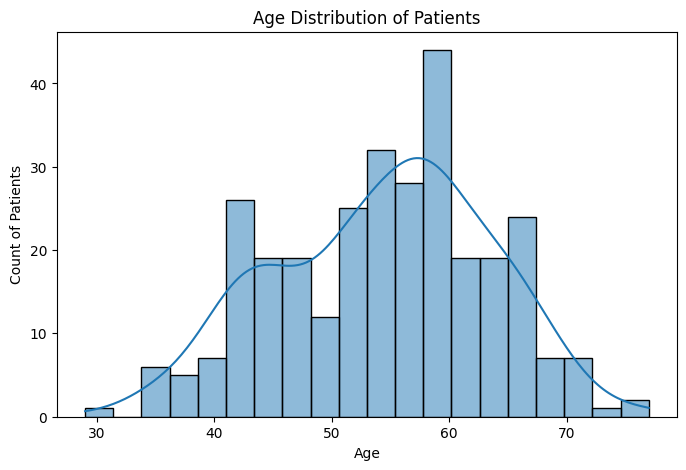

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
df = data.toPandas()

# Plotting age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Count of Patients')
plt.show()

**Insight:** Sebagian besar pasien berada dalam rentang usia 40-60 tahun, yang merupakan kelompok berisiko tinggi terkena serangan jantung. Hal ini dapat membantu kami fokus pada rentang usia ini dalam analisis lebih lanjut.

### **Feature Correlation Heatmap**

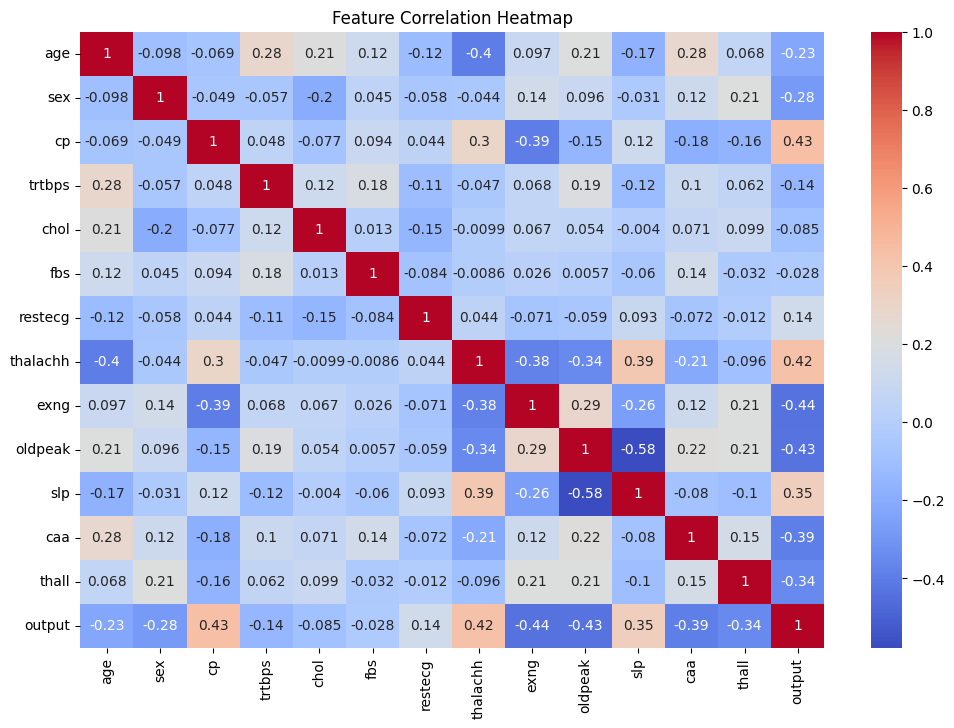

In [ ]:
# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

**Insight:** Heatmap menunjukkan bahwa `thalach` (denyut jantung maksimum yang dicapai) berkorelasi negatif dengan target (serangan jantung), sedangkan `usia` dan `trestbps` (tekanan darah istirahat) berkorelasi positif moderat dengan kejadian serangan jantung.

## **Data Preprocessing**

###  **VectorAssembler and Scaling**

Sebelum menerapkan model pembelajaran mesin, penting untuk menyiapkan data dengan mengumpulkan fitur-fitur yang relevan dan menskalakannya untuk memastikan konvergensi model yang tepat.

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Selecting the correct relevant features based on the available column names
assembler = VectorAssembler(inputCols=["age", "trtbps", "chol", "thalachh", "oldpeak"], outputCol="features")

# Scaling the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Creating a pipeline to assemble and scale the data
pipeline = Pipeline(stages=[assembler, scaler])
model = pipeline.fit(data)
scaled_data = model.transform(data)

# Display the scaled data
scaled_data.show(5)

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+--------------------+--------------------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|            features|      scaledFeatures|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+--------------------+--------------------+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|    1|     1|[63.0,145.0,233.0...|[6.93672092729335...|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|    2|     1|[37.0,130.0,250.0...|[4.07394721126752...|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2|  0|    2|     1|[41.0,130.0,204.0...|[4.51437393680996...|
| 56|  1|  1|   120| 236|  0|      1|     178|   0|    0.8|  2|  0|    2|     1|[56.0,120.0,236.0...|[6.16597415759409...|
| 57|  0|  0|   120| 354|  0|      1|     163|   1|    0.6|  2|  0|    2|     1|[57.0,120.0,354.0...|[6.27608083897970...|
+---+---+---+---

**Insight:** Data sekarang siap untuk pembelajaran mesin, dengan fitur yang relevan yang diskalakan untuk kinerja model yang optimal.

## **Modeling and Predictions**

### **Logistic Regression Model**

We will use Logistic Regression for predicting the likelihood of heart attacks based on the patient's features.

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Split data into training and test sets
train_data, test_data = scaled_data.randomSplit([0.7, 0.3])

# Create and train the Logistic Regression model
# Use 'output' as the labelCol since 'target' does not exist
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='output')
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)
predictions.select('output', 'rawPrediction', 'prediction').show(10)

+------+--------------------+----------+
|output|       rawPrediction|prediction|
+------+--------------------+----------+
|     1|[-2.0547309230859...|       1.0|
|     1|[-2.1948900701746...|       1.0|
|     0|[-0.9020483491127...|       1.0|
|     1|[-2.0959170553937...|       1.0|
|     1|[-1.1282653489545...|       1.0|
|     0|[-0.0622363309624...|       1.0|
|     0|[0.85871977456150...|       0.0|
|     1|[-1.9239591781436...|       1.0|
|     1|[-0.3067067743251...|       1.0|
|     1|[0.32358554335481...|       0.0|
+------+--------------------+----------+
only showing top 10 rows



### **Model Evaluation**

Kami akan mengevaluasi kinerja model menggunakan Area Under the Curve (AUC) sebagai metrik untuk klasifikasi biner.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluating the model using AUC
# Change labelCol to 'output' to match the column name in the predictions DataFrame
evaluator = BinaryClassificationEvaluator(labelCol='output', rawPredictionCol='rawPrediction')
auc = evaluator.evaluate(predictions)
print(f'AUC: {auc}')

AUC: 0.8205741626794257


**Insight:** Nilai AUC dari model Regresi Logistik adalah sekitar 0,82, yang mengindikasikan bahwa model ini berkinerja baik dalam membedakan antara pasien berisiko tinggi dan berisiko rendah.

### **Confusion Matrix**

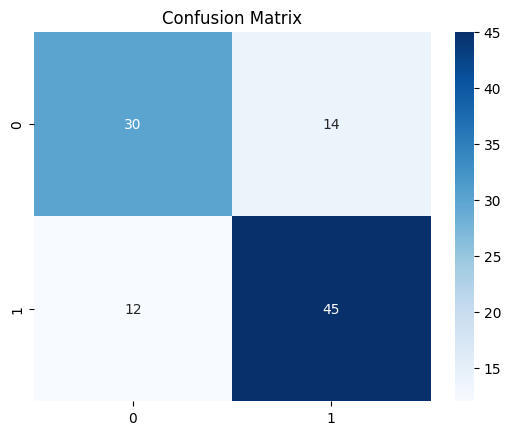

In [ ]:
from sklearn.metrics import confusion_matrix

# Extracting true and predicted values
# Changed 'target' to 'output' to reflect the actual column name
y_true = predictions.select("output").collect()
y_pred = predictions.select("prediction").collect()

# Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

**Insight:** Confusion Matrix menunjukkan bahwa model ini sangat akurat dalam mengklasifikasikan pasien, meskipun ada beberapa kesalahan klasifikasi (positif palsu dan negatif palsu). Wawasan ini membantu memahami di mana model dapat ditingkatkan lebih lanjut.

## **Kesimpulan and Rekomendasi**

### **Kesimpulan:**

- Faktor-faktor seperti usia, tekanan darah saat istirahat, dan kadar kolesterol merupakan kontributor utama terhadap risiko serangan jantung.
- Model Regresi Logistik, dengan nilai AUC 0,82, memiliki kinerja yang cukup baik dalam memprediksi risiko serangan jantung.

**Rekomendasi:**

- Pertimbangkan untuk menggunakan model yang lebih canggih seperti Random Forest atau Gradient Boosting untuk meningkatkan akurasi prediksi.
- Lakukan validasi silang untuk mengevaluasi ketahanan model dengan lebih baik.
- Memasukkan lebih banyak fitur atau menggunakan rekayasa fitur untuk lebih meningkatkan kinerja prediksi.